In [5]:
using Plots
using Colors

"Set the default plot size to something that fits a cell"
default(size = (800, 300))

Plots.default

In [6]:
"Enumerate possible states of a single cell"
@enum InfectionStatus uninfected infected dead recovered immune

"Data structure containing the infection status of a cell"
mutable struct Cell
    status::InfectionStatus
    infection_time::Int8
end

"Parameters for a simulation"
mutable struct Parameters
    infection_rate::Float32
    reinfection_rate::Float32
    death_probability::Float32
    recovery_time::Int8
    immunity_rate::Float32
end

"Fast spread with low lethality and high immunity rate"
parameters = Parameters(0.2, 0.001, 0.02, 8, 0.1)

parameters

In [7]:
"Create a 2D array of cells with 4 infected cells in the middle"
function create_map(width::Int64=32, height::Int64=32, immunity_rate::Float32=0.0)
    cells = Array{Cell}(undef, width, height)
    for i in 1:size(cells)[1]
        for j in 1:size(cells)[2]
            if rand(1)[1] < immunity_rate
                cells[i,j] = Cell(immune, 0)
            else
                cells[i,j] = Cell(uninfected, 0)
            end
        end
    end
    cells[width÷2,height÷2].status = infected
    cells[width÷2+1,height÷2].status = infected
    cells[width÷2,height÷2+1].status = infected
    cells[width÷2+1,height÷2+1].status = infected
    return cells
end

"Map the cells to colors for plotting"
function to_colors(cell::Cell)
    if cell.status == uninfected
        return RGB(0.0,0.8,0.0)
    end
    if cell.status == immune
        return RGB(0.2,0.2,1.0)
    end
    if cell.status == infected
        return RGB(0.8,0.0,0.0)
    end
    if cell.status == dead
        return RGB(0.1,0.1,0.1)
    end
    if cell.status == recovered
        return RGB(0.0,0.0,0.8)
    end
end

"""
Run the interaction between one cell and a neighbour.

If the neighbour is infected, it infect this cell with the propability
parameters.infection_rate or, if this cell is recovered, parameters.reinfection_rate.
"""
function interact!(new_cell::Cell, other_cell::Cell, parameters::Parameters)
    if new_cell.status == uninfected && other_cell.status == infected
        if rand(1)[1] < parameters.infection_rate
            new_cell.status = infected
            new_cell.infection_time = 0
        end
    end
    if new_cell.status == recovered && other_cell.status == infected
        if rand(1)[1] < parameters.reinfection_rate
            new_cell.status = infected
            new_cell.infection_time = 0
        end
    end
end

"""
Update a single cell, not accounting for it's interactions with the neighbours.
"""
function update!(new_cell::Cell, parameters::Parameters)
    if new_cell.status == infected
        new_cell.infection_time += 1
        if new_cell.infection_time > parameters.recovery_time
            new_cell.status = recovered
        end
        if rand(1)[1] < parameters.death_probability
            new_cell.status = dead
        end
    end
end

"""
Update the cells in the 2D array of Cells, using given parameters.
"""
function update(cells::Matrix{Cell}, parameters::Parameters)
    new_cells = deepcopy(cells)
    for i in 1:size(cells)[1]
        for j in 1:size(cells)[2]
            update!(new_cells[i,j], parameters)
        end
    end
    for i in 1:size(cells)[1]-1
        for j in 1:size(cells)[2]
            interact!(new_cells[i,j], cells[i+1,j], parameters)
            interact!(new_cells[i+1,j], cells[i,j], parameters)
        end
    end
    for i in 1:size(cells)[1]
        for j in 1:size(cells)[2]-1
            interact!(new_cells[i,j], cells[i,j+1], parameters)
            interact!(new_cells[i,j+1], cells[i,j], parameters)
        end
    end
    return new_cells
end

"Count the current number of infections"
function count_infections(cells::Matrix{Cell})
    infections = 0
    deaths = 0
    for i in 1:size(cells)[1]
        for j in 1:size(cells)[2]
            if cells[i,j].status == infected
                infections += 1
            end
        end
    end
    return infections
end

"Count the number of dead cells"
function count_deaths(cells::Matrix{Cell})
    deaths = 0
    for i in 1:size(cells)[1]
        for j in 1:size(cells)[2]
            if cells[i,j].status == dead
                deaths += 1
            end
        end
    end
    return deaths
end

count_deaths

[4]

┌ Info: Saved animation to 
│   fn = /u/24/rantahj1/unix/src/julia-introduction/notebooks/pandemic.gif
└ @ Plots /u/24/rantahj1/unix/.julia/packages/Plots/YVapH/src/animation.jl:104


Plots.AnimatedGif("/u/24/rantahj1/unix/src/julia-introduction/notebooks/pandemic.gif")
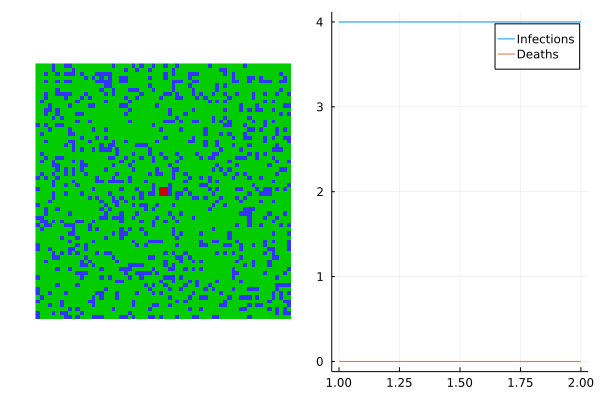

In [8]:
"The map of cells (a 2D array)"
cells = create_map(64, 64, parameters.infection_rate)
"An array of the infection counts at each time step"
infections = [count_infections(cells)]
"An array of the death counts at each time step"
deaths = [count_deaths(cells)]

print(infections)

"Build the animation frames by running simulation steps and generating a plot"
anim = @animate for i ∈ 1:200
    cells = update(cells, parameters)
    append!(infections, count_infections(cells))
    append!(deaths, count_deaths(cells))
    
    l = @layout [a b]
    p1 = plot(to_colors.(cells),legend=false, border=:none)
    p2 = plot([infections, deaths], label = ["Infections" "Deaths"])
    frame = plot(p1, p2, layout = l)
    frame
end

gif(anim, "pandemic.gif", fps = 5)